# HWRS 528 IMP04
## Optimization of performance by automated calibration of parameters
### 1. Import Python packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import LRC_modelSubprograms as lrc      # Leaf River Catchment model subprograms
from scipy.optimize import minimize     # Optimization package for par optimization
import datetime as dt

### 2. Begin model simulation for Leaf River
#### 2.1 Load data, choose time period, and specify model parameters

In [2]:
#==== Load Leaf River Catchment Data as a DataFrame ===============================
LRData = pd.read_csv('../LeafRiverDaily.csv')

#==== Get a number of datapoints ==================================================
Ndata = LRData.shape[0]
Nvars = LRData.shape[1]

#==== Choose a simulation time period and set up time vector ======================
Period_Start = 0; Period_End = 365*3                # select time period to work with
Time = np.arange(0, Period_End, 1)
NTime = len(Time)

#==== Set number of initial time steps to use as spin-up ==========================
# Metrics are not computed on this period
SpinUp = 90                                         # select 90-day spin-up period

#==== Get data for the desired period =============================================
PPobs = LRData.PP[Time].to_numpy()                  # Convert from DataFrame to numpy
PEobs = LRData.PE[Time].to_numpy()                  # arrays to avoid indexing issues
QQobs = LRData.QQ[Time].to_numpy()

#==== Determine max values for each variable ======================================
PPobs_max = np.max(PPobs)
PEobs_max = np.max(PEobs)
QQobs_max = np.max(QQobs)

#==== Specify model parameters ====================================================
NRes = 2; ResIdex = np.arange(0, NRes, 1)

#==== Specify process parameter values for simulation==============================
ParFlag = 2

if ParFlag == 0:
#==== Midpoint values =========================================================
    Theta_C1  = 155.0;    # Upper Soil Zone Capacity
    Theta_P1  = 1.0;     # Evapotranspiration Parameter (Reducing value increases ET)  
    Theta_K12 = 0.25;    # Drainage to Lower Soil Zone (Increasing value increases Drainage) 
    Theta_K13 = 0.55;    # Interflow Parameter (Increasing value increases Interflow)  
    Theta_K2Q = 0.0032;  # Baseflow Parameter (Increasing value makes baseflow recessions steeper) 
    Theta_K3Q = 0.5;     # Channel Routing Parameter (Increasing value reduces temporal dispersion)

elif ParFlag == 1:
#==== Manually calibrated values ==============================================
    Theta_C1  = 51.0;    # Upper Soil Zone Capacity
    Theta_P1  = 0.75;     # Evapotranspiration Parameter (Reducing value increases ET)  
    Theta_K12 = 0.25;    # Drainage to Lower Soil Zone (Increasing value increases Drainage) 
    Theta_K13 = 0.04;    # Interflow Parameter (Increasing value increases Interflow)  
    Theta_K2Q = 0.0002;  # Baseflow Parameter (Increasing value makes baseflow recessions steeper) 
    Theta_K3Q = 0.56;     # Channel Routing Parameter (Increasing value reduces temporal dispersion)

elif ParFlag == 2:
 #==== Manually calibrated values (2nd set) ====================================
    Theta_C1  = 65.0;    # Upper Soil Zone Capacity
    Theta_P1  = .5;     # Evapotranspiration Parameter (Reducing value increases ET)  
    Theta_K12 = 0.25;    # Drainage to Lower Soil Zone (Increasing value increases Drainage) 
    Theta_K13 = 0.25;    # Interflow Parameter (Increasing value increases Interflow)  
    Theta_K2Q = 0.0002;  # Baseflow Parameter (Increasing value makes baseflow recessions steeper) 
    Theta_K3Q = 0.6;     # Channel Routing Parameter (Increasing value reduces temporal dispersion)

Pars = np.zeros(6)

Pars[0] = Theta_C1;  Pars[1] = Theta_P1;  Pars[2] = Theta_K12
Pars[3] = Theta_K13; Pars[4] = Theta_K2Q; Pars[5] = Theta_K3Q

#### 2.2 Run catchment model for Selected time period

In [3]:
lrc.MainCatchModel(Pars, PPobs, PEobs, QQobs, NRes)

1.828388633926709

### 3. Optimize values

In [57]:
#==== Set number of iterations for optimization =========================
NIterations = 10000

#==== Set paramter bounds ===============================================
            # Theta_C1  Theta_P1  Theta_K12  Theta_K13   Theta_K2Q    Theta_K3Q
ParBounds = [[10,300], [0.5,1.5], [0.0,0.5], [0.0,0.9], [0.0001,0.1], [0.1,0.9]]

#==== Perform optimization search =======================================
OptSearchResult = minimize(lrc.MainCatchModel, Pars, args = (PPobs, PEobs, QQobs, NRes),
                  bounds=ParBounds, method='nelder-mead',
                  options={'disp':True, 'return_all':True,'maxiter':NIterations}
                  )


Optimization terminated successfully.
         Current function value: 1.104930
         Iterations: 1271
         Function evaluations: 1900


In [6]:
#==== Output from the DSM Optimization Search ===========================
OptimizedPars = np.array([7.71075051e+01, 5.00000000e-01,
                            4.90068850e-02, 1.87561126e-02,                           
                            1.00000000e-04, 5.76093034e-01])

In [58]:
#==== Track evolution of KGEss ==========================================

ParSets = OptSearchResult['allvecs']
NParSets   = len(ParSets)
ParSetsidx = np.arange(0, NParSets, 1)
KGEss      = np.zeros(NParSets)

for i in ParSetsidx:
    Pars = ParSets[i]
    KGEss[i] = lrc.MainCatchModel(Pars, PPobs, PEobs, QQobs, NRes)

KGEss = KGEss**-1

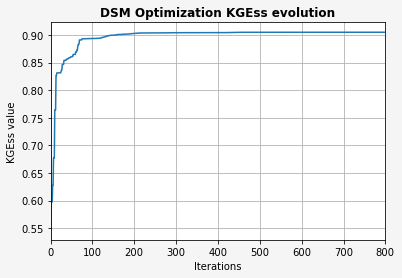

In [61]:
#=== Plot KGEss evolution ==============================================

plt.figure(facecolor='whitesmoke')
plt.grid('--k')
plt.xlabel('Iterations')
plt.ylabel('KGEss value')
plt.xlim(0,800)

plt.title('DSM Optimization KGEss evolution',
          fontweight='bold')
plt.plot(KGEss)

In [62]:
#==== Compile lists of parameter evolution ==============================

def ParValues(array):
    NParSets   = len(array)
    ParSetsidx = np.arange(0, NParSets, 1)

    Theta_C1List  = np.zeros(NParSets); Theta_P1List  = np.zeros(NParSets)
    Theta_K12List = np.zeros(NParSets); Theta_K13List = np.zeros(NParSets)
    Theta_K2QList = np.zeros(NParSets); Theta_K3QList = np.zeros(NParSets)

    for i in ParSetsidx:
        Theta_C1List[i]  = array[i][0]
        Theta_P1List[i]  = array[i][1]
        Theta_K12List[i] = array[i][2]
        Theta_K13List[i] = array[i][3]
        Theta_K2QList[i] = array[i][4]
        Theta_K3QList[i] = array[i][5]

    return [Theta_C1List, Theta_P1List, Theta_K12List,
            Theta_K13List, Theta_K2QList, Theta_K3QList]

# [Theta_C1List, Theta_P1List, Theta_K12List, Theta_K13List, Theta_K2QList, Theta_K3QList] = ParValues(ParSets)

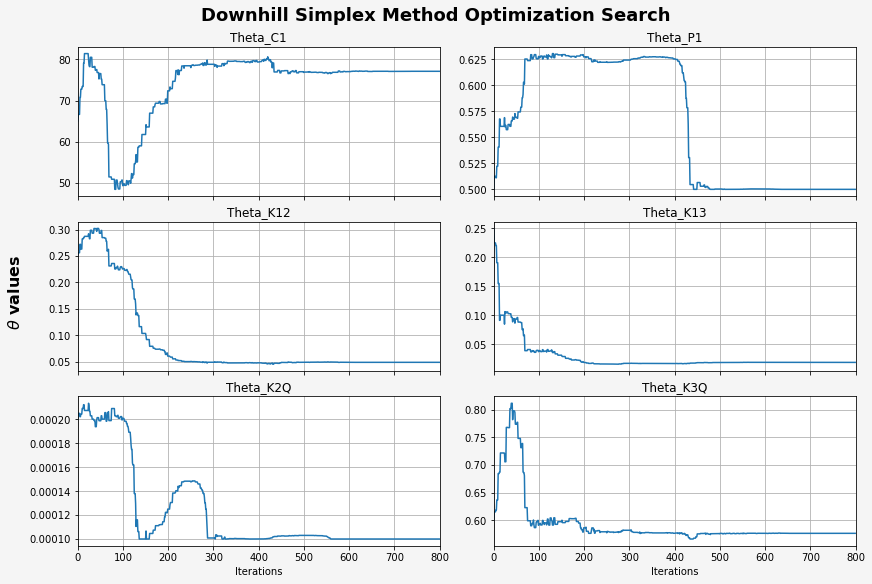

In [63]:
#==== Plot DSM optimization search for individual parameters ============

AllVectorsList = ParValues(ParSets)                         # Call parameter lists from minimize_fun output
Iter_Start = 0; Iter_End = 800                              # Set iteration range for plotting
ParNames = ['Theta_C1', 'Theta_P1', 'Theta_K12',
            'Theta_K13', 'Theta_K2Q', 'Theta_K3Q']

fig, axs = plt.subplots(nrows=3, ncols=2,                   # initialize figure and 3x2 subplots
                        figsize=(12,8),
                        sharex=True,
                        constrained_layout=True)
fig.supylabel(r'$\theta$ values',                           # set super y label
              fontsize=16,
              fontweight='bold')
fig.suptitle('Downhill Simplex Method Optimization Search', # set super title of figure
             fontsize=18,
             fontweight='bold')
fig.set_facecolor('whitesmoke')

idx = 0                                                     # initialize Parameter index value
for i in np.arange(0,3,1):                                  # iterate over rows    (3)
    for j in np.arange(0,2,1):                              # iterate over columns (2)
        ParList = AllVectorsList[idx][Iter_Start:Iter_End]  # set parameter list and truncate to 800 iterations
        ParName = ParNames[idx]                             # grab parameter name from above list
        axs[i,j].plot(ParList)
        axs[i,j].set_xlim(Iter_Start,Iter_End)      
        axs[i,j].grid('--k')
        axs[2,j].set_xlabel('Iterations')
        axs[i,j].set_title(ParName)
        idx += 1                                            # increase parameter index by one

In [8]:
#==== Linear reservoir module (for one time step) ================================

def LinRes(Xin, U, Kpar):                   # Define LinRes function subprogram

    Y = Kpar*Xin                            # Compute QQ
    Xout = Xin - Y + U                      # Update state variable

    return [Y, Xout]                        # Return computed quantities

#==== Channel routing module (for one time step) ====================================================

def NashCasc(OF, NRes, XX3in, Theta_K3Q):   # Define NashCasc function subprogram

    ResIdx = np.arange(0, NRes, 1)          # Set loop vector on tanks (int values)
    UU     = OF                             # UU is set to be input to first tank
    XX3out = np.zeros(NRes)                 # Initialize array to recieve XX3out
    YY     = np.zeros(NRes)                 # Initialize array to recieve YY (individual tank outflows)

    for i in ResIdx:
        [YY[i], XX3out[i]] = LinRes(XX3in[i], UU, Theta_K3Q)
        UU = YY[i]                          # set UU (inflow to next tank) to be outflow from previous tank
    SF = UU                                 # Get output from last tank

    return [SF, XX3out]                     # Return computed quantities (surface flow and state variable of last tank)

#==== Lower Soil Zone Module (for one time step) ======================================================

def LowerSoilZone(XX2in, RG, Theta_K2Q):    # Calculate lower soil zone subprocesses using LinRes

    [BF, XX2out] = LinRes(XX2in, RG, Theta_K2Q) # Use Recharge as input for LSZ from upper soil zone tank
    return [BF, XX2out]

#==== Upper Soil Zone Module (for one time step) ======================================================

def UpperSoilZone(XX1in, PP, PE, Theta_C1, Theta_P1, Theta_K13, Theta_K12):
    
    PX   = np.maximum(0, PP + XX1in - Theta_C1)   # Determines excess precipitation, part 1 of OF
    IF   = Theta_K13*XX1in                        # Determines lateral drainage, part 2 of OF
    OF   = PX + IF                                # Overland flow that will become the input for NashCasc
    XX1a = XX1in - IF                             # Remainder of water content (Method of Operator Splitting)
    AE   = np.minimum(XX1a, PE*(XX1a/Theta_C1)**Theta_P1) # Actual evaporation limited by PE or water content
    XX1b = XX1a - AE                              # Remainder of water content 
    RG   = Theta_K12*XX1b                         # Recharge
    XX1c = XX1b - RG                              # Remainder of water content
    XX1out = XX1c + PP - PX                       # State variable at end of time step

    return [OF, PX, IF, AE, RG, XX1out]

#==== Catchment Model (for one time step) ======================================================

def CatchModel(Inputs, InStates, Pars, NRes):

    # Get input values for time step
    PP = Inputs[0]
    PE = Inputs[1]

    # Get state values at beginning of time step
    XX1in  = InStates[0]
    XX2in  = InStates[1]
    XX3in  = np.zeros(NRes)
    ResIdx = np.arange(0, NRes, 1)
    for i in ResIdx:
        XX3in[i] = InStates[i+2]

    # Get Par values
    Theta_C1  = Pars[0]
    Theta_P1  = Pars[1]
    Theta_K12 = Pars[2]
    Theta_K13 = Pars[3]
    Theta_K2Q = Pars[4]
    Theta_K3Q = Pars[5]

    # Initialize Output array
    Outputs   = np.zeros(2)
    OutStates = np.zeros(NRes+2)
    IntFluxes = np.zeros(6)

    # Run model components
    [OF, PX, IF, AE, RG, XX1out] = UpperSoilZone(XX1in, PP, PE,
                                                Theta_C1, Theta_P1,
                                                Theta_K13, Theta_K12)
    [BF, XX2out] = LowerSoilZone(XX2in, RG, Theta_K2Q)
    [SF, XX3out] = NashCasc(OF, NRes, XX3in, Theta_K3Q)
    QQ           = SF + BF

    # Compile outputs for time step
    Outputs[0] = QQ
    Outputs[1] = AE

    # Compile and get state values at end of time step
    OutStates[0] = XX1out
    OutStates[1] = XX2out
    for i in ResIdx:
        OutStates[i+2] = XX3out[i]

    # Compile internal fluxes for time step
    IntFluxes[0] = OF; IntFluxes[1] = PX; IntFluxes[2] = IF
    IntFluxes[3] = RG; IntFluxes[4] = BF; IntFluxes[5] = SF

    return [Outputs, OutStates, IntFluxes]

def MainCatchModel(Pars, PPobs, PEobs, QQobs, NRes):
# def MainCatchModel(PPobs, PEobs, Theta_C1,
#                    Theta_P1, Theta_K12, Theta_K13,
#                    Theta_K2Q, Theta_K3Q, NRes):
    
    NTime = len(PPobs)              # Get length of time vector
    Time  = np.arange(0, NTime, 1)  # Set up time vector (of integer values)

    # Pack parameter values in Par array
    # Npar = 6; Pars = np.zeros(Npar)
    # Pars[0] = Theta_C1;  Pars[1] = Theta_P1;  Pars[2] = Theta_K12
    # Pars[3] = Theta_K13; Pars[4] = Theta_K2Q; Pars[5] = Theta_K3Q

    Theta_K2Q = Pars[4]

    # Initialize model state arrays
    InStates = np.zeros(NRes+2); OutStates = InStates.copy()
    InStates[1] = QQobs[0]/Theta_K2Q

    # Initialize arrays
    Inputs = np.zeros(2); Outputs = np.zeros(2); IntFluxes = np.zeros(6)
    QQsim  = np.zeros(NTime); AEsim = np.zeros(NTime)

    OF = np.zeros(NTime); PX = np.zeros(NTime); IF = np.zeros(NTime)
    RG = np.zeros(NTime); BF = np.zeros(NTime); SF = np.zeros(NTime)
    XX1 = np.zeros(NTime+1); XX2 = np.zeros(NTime+1)
    XX3 = np.zeros([NTime+1, NRes])

    for t in Time:
        Inputs[0] = PPobs[t]; Inputs[1] = PEobs[t]
        [Outputs, OutStates, IntFluxes] = CatchModel(Inputs, InStates, Pars, NRes)

        QQsim[t] = Outputs[0].copy(); AEsim[t] = Outputs[1].copy()
        OF[t] = IntFluxes[0]; PX[t] = IntFluxes[1]; IF[t] = IntFluxes[2]
        RG[t] = IntFluxes[3]; BF[t] = IntFluxes[4]; SF[t] = IntFluxes[5]
        XX1[t+1] = OutStates[0]; XX2[t+1] = OutStates[1]
        ResIdx = np.arange(0, NRes, 1)
        for i in ResIdx:
            XX3[t+1, i] = OutStates[i+2]
        InStates = OutStates

    return [QQsim, AEsim]

In [65]:
#==== Create Diagnostic Plots ===========================================================

def DiagnosticPlots(fignum,Time,QQsim,QQobs):
    
    MuQQsim = np.mean(QQsim);                                    # Compute mean of QQsim
    MuQQobs = np.mean(QQobs);                                    # Compute mean of QQobs
    SigQQsim = np.std(QQsim);                                    # Compute std  of QQsim
    SigQQobs = np.std(QQobs);                                    # Compute std  of QQobs
    rho     = np.corrcoef(QQsim,QQobs)[0, 1];                    # Compute Rho
    rho_srt = np.corrcoef(np.sort(QQsim),np.sort(QQobs))[0, 1];  # Compute Rho of sorted
    Lab1 = f'Mu_sim = {MuQQsim:.2f}, Sig_sim = {SigQQsim:.2f}'   # Create Labels
    Lab2 = f'Mu_obs = {MuQQobs:.2f}, Sig_obs = {SigQQobs:.2f}'   # Create Labels
 
    QQsimL    = np.log(QQsim);                                   # Create Log(QQsim)
    QQobsL    = np.log(QQobs);                                   # Create Log(QQobs)
    MuQQsimL  = np.mean(QQsimL);                                 # Compute mean of QQsimL
    MuQQobsL  = np.mean(QQobsL);                                 # Compute mean of QQobsL
    SigQQsimL = np.std(QQsimL);                                  # Compute std  of QQsimL
    SigQQobsL = np.std(QQobsL);                                  # Compute std  of QQobsL
    rhoL      = np.corrcoef(QQsimL,QQobsL)[0, 1];                   # Compute Rho
    rho_srtL  = np.corrcoef(np.sort(QQsimL),np.sort(QQobsL))[0,1];  # Compute Rho of sorted
    Lab1L = f'Mu_simL = {MuQQsimL:.2f}, Sig_simL = {SigQQsimL:.2f}' # Create Labels
    Lab2L = f'Mu_obsL = {MuQQobsL:.2f}, Sig_obsL = {SigQQobsL:.2f}' # Create Labels

    # First Row of Plots
    plt.figure(num = fignum);                                # Set figure number
    fig_width = 14; fig_height = 4;                          # Set figure width and height
    fig, ax1 = plt.subplots(nrows=1,ncols=1,\
                            figsize=(fig_width,fig_height)); # Create figure
    Period_Start = Time[366]; Period_End = Time[730];           # Set plot time period
    # Time Series Plot
    ax1.set_xlim(Period_Start,Period_End);                   # Fix xaxis limits
    ax1.set_xlabel('Time (Days)');                           # Set the x-axis label
    ax1.set_ylabel('QQ (mm)');                               # Set the x-axis label
    ax1.set_title('CatchModel: Time Series Plot');           # Add plot title
    ax1.grid('k--');                                         # Turn on grid lines
    B = [0,1.5*np.max(QQobs)];                               # Get the y-axis limits 
    ax1.set_ylim(B);                                         # Set the y-axis limits
    color1 = 'r.'; color2 = 'b';                             # Choose line color
    ax1.plot(Time,QQobs,color1,label="QQ observed");         # Plots the Observed Flows
    ax1.plot(Time,QQsim,color2,label="QQ simulated");        # Plots the Simulated Flows
    ax1.legend(loc=2);
    
    # Second Row of Plots
    fignum = fignum + 1;
    plt.figure(num = fignum);                                # Set figure number
    fig_width = 14; fig_height = 6.5;                        # Set figure width and height
    fig, ax2 = plt.subplots(nrows=1,ncols=2,\
                            figsize=(fig_width,fig_height)); # Create figure
    # Scatterplot
    ax2[0].set_xlabel('QQobs',color='r');                    # Set the x-axis label
    ax2[0].set_ylabel('QQsim',color='b');                    # Set the y-axis label
    ax2[0].grid('k--');                                      # Turn on grid lines
    B = [0,1.25*np.max(QQobs)];                              # Get the axis limits 
    ax2[0].set_xlim(B);                                      # Set the x-axis limits
    ax2[0].set_ylim(B);                                      # Set the y-axis limits
    ax2[0].plot(QQobs,QQsim,'k.');                           # Plots a scatterplot
    ax2[0].plot(B,B,'k:');                                   # Plot 1:1 line
    ax2[0].set_title(f'Rho = {rho:.2f}');                    # Add plot title
    ax2[0].plot(B,[MuQQsim,MuQQsim],'b:',label = Lab1);
    ax2[0].tick_params(axis='y',labelcolor = 'b');           # Set the yaxis tick color
    ax2[0].plot([MuQQobs,MuQQobs],B,'r:',label = Lab2);
    ax2[0].tick_params(axis='x',labelcolor = 'r');           # Set the xaxis tick color
    ax2[0].legend(loc=2);
    # Q-Q Plot
    ax2[1].set_xlabel('sort(QQobs)',color='r');              # Set the x-axis label
    ax2[1].set_ylabel('sort(QQsim)',color='b');              # Set the y-axis label
    ax2[1].grid('k--');                                      # Turn on grid lines
    B = [0,1.25*np.max(QQobs)];                              # Get the axis limits 
    ax2[1].set_xlim(B);                                      # Set the x-axis limits
    ax2[1].set_ylim(B);                                      # Set the y-axis limits
    ax2[1].plot(np.sort(QQobs),np.sort(QQsim),'k.');         # Plots a Q-Q Plot
    ax2[1].plot(B,B,'k:');                                   # Plot 1:1 line
    ax2[1].set_title(f'Rho = {rho_srt:.2f}');                # Add plot title
    #ax2[1].plot(B,[MuQQsim,MuQQsim],'b:',label = Lab1);
    ax2[1].tick_params(axis='y',labelcolor = 'b');           # Set the yaxis tick color
    #ax2[1].plot([MuQQobs,MuQQobs],B,'r:',label=Lab2);
    ax2[1].tick_params(axis='x',labelcolor = 'r');           # Set the xaxis tick color
    #ax2[1].legend(loc=2);

    #Third Row of Plots
    fignum = fignum + 1;    
    plt.figure(num = fignum);                               # Set figure number
    fig_width = 14; fig_height = 4;                         # Set figure width and height
    fig, ax3 = plt.subplots(nrows=1,ncols=1,\
                            figsize=(fig_width,fig_height)); # Create figure
    # Time Series Log Plot
    ax3.set_xlim(Period_Start,Period_End);                # Fix xaxis limits
    ax3.set_xlabel('Time (Days)');                        # Set the x-axis label
    ax3.set_ylabel('Log(QQ)');                            # Set the x-axis label
    ax3.set_title('CatchModel: Time Series Plot');        # Add plot title
    ax3.grid('k--');                                      # Turn on grid lines
    B = [0.1,1.5*np.max(QQobs)];                          # Get the y-axis limits 
    ax3.set_ylim(B);                                      # Set the y-axis limits
    color1 = 'r.'; color2 = 'b';                          # Choose line color
    ax3.semilogy(Time,QQobs,color1,label="QQ observed");  # Plots the Observed Flows
    ax3.semilogy(Time,QQsim,color2,label="QQ simulated"); # Plots the Simulated Flows
    ax3.legend(loc=2);

    # Fourth Row of Plots
    fignum = fignum + 1;
    plt.figure(num = fignum);                                # Set figure number
    fig_width = 14; fig_height = 6.5;                        # Set figure width and height
    fig, ax4 = plt.subplots(nrows=1,ncols=2,\
                            figsize=(fig_width,fig_height)); # Create figure
    # Scatterplot
    ax4[0].set_xlabel('Log(QQobs)',color='r');               # Set the x-axis label
    ax4[0].set_ylabel('Log(QQsim)',color='b');               # Set the y-axis label
    ax4[0].grid('k--');                                      # Turn on grid lines
    B = [0.1,1.25*np.max(QQobs)];                            # Get the axis limits 
    ax4[0].set_xlim(B);                                      # Set the x-axis limits
    ax4[0].set_ylim(B);                                      # Set the y-axis limits
    ax4[0].loglog(QQobs,QQsim,'k.');                         # Plots a scatterplot
    ax4[0].loglog(B,B,'k:');                                 # Plot 1:1 line
    ax4[0].set_title(f'Rho = {rhoL:.2f}');                   # Add plot title
    ax4[0].loglog(B,[MuQQsim,MuQQsim],'b:',label = Lab1L);
    ax4[0].tick_params(axis='y',labelcolor = 'b');           # Set the yaxis tick color
    ax4[0].loglog([MuQQobs,MuQQobs],B,'r:',label = Lab2L);
    ax4[0].tick_params(axis='x',labelcolor = 'r');           # Set the xaxis tick color
    ax4[0].legend(loc=2);
    # Q-Q Plot
    ax4[1].set_xlabel('sort(Log(QQobs)',color='r');          # Set the x-axis label
    ax4[1].set_ylabel('sort(Log(QQsim))',color='b');         # Set the y-axis label
    ax4[1].grid('k--');                                      # Turn on grid lines
    B = [0.1,1.25*np.max(QQobs)];                            # Get the axis limits 
    ax4[1].set_xlim(B);                                      # Set the x-axis limits
    ax4[1].set_ylim(B);                                      # Set the y-axis limits
    ax4[1].loglog(np.sort(QQobs),np.sort(QQsim),'k.');       # Plots a Q-Q Plot
    ax4[1].loglog(B,B,'k:');                                 # Plot 1:1 line
    ax4[1].set_title(f'Rho = {rho_srtL:.2f}');               # Add plot title
    #ax4[1].plot(B,[MuQQsim,MuQQsim],'b:',label = Lab1);
    ax4[1].tick_params(axis='y',labelcolor = 'b');           # Set the yaxis tick color
    #ax4[1].plot([MuQQobs,MuQQobs],B,'r:',label=Lab2);
    ax4[1].tick_params(axis='x',labelcolor = 'r');           # Set the xaxis tick color
    #ax4[1].legend(loc=2);
    
    return

In [66]:
# Run Catchment Model for Selected time period ================================
OptimizedPars = OptSearchResult['x']
[QQsim, AEsim] = MainCatchModel(OptimizedPars, PPobs, PEobs, QQobs, NRes)

# Compute Performance Metrics for Selected Period =======================================
# Print Metrics

iPrint = 1; # Turn on print flag
[MSE,NSE,NSEL,KGEss,KGE,alpha,beta,rho] = lrc.PerfMetrics(QQsim,QQobs,SpinUp,iPrint)


MSE = 3.57 NSE = 0.73 KGEss = 0.91 Alpha = 1.00 Beta = 1.00 Rho = 0.87 NSEL = 0.51


<Figure size 432x288 with 0 Axes>

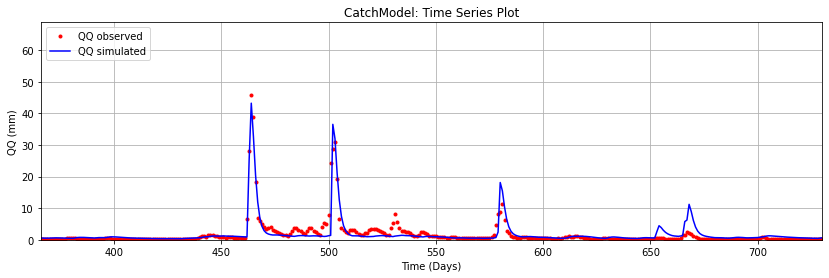

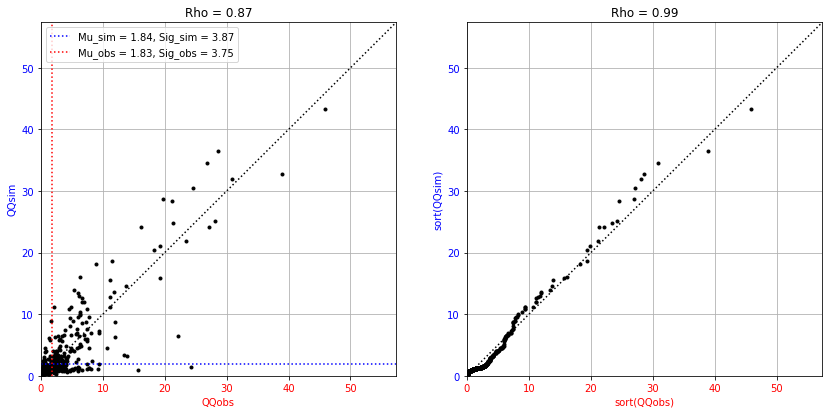

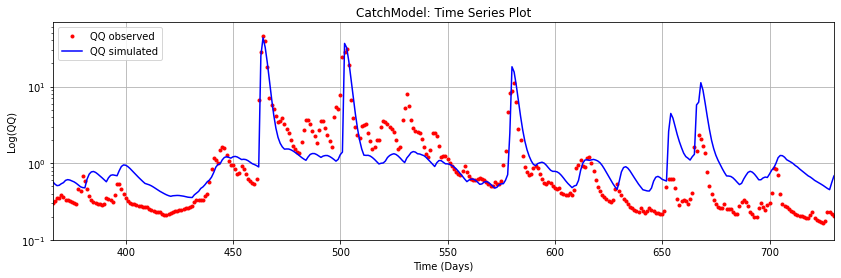

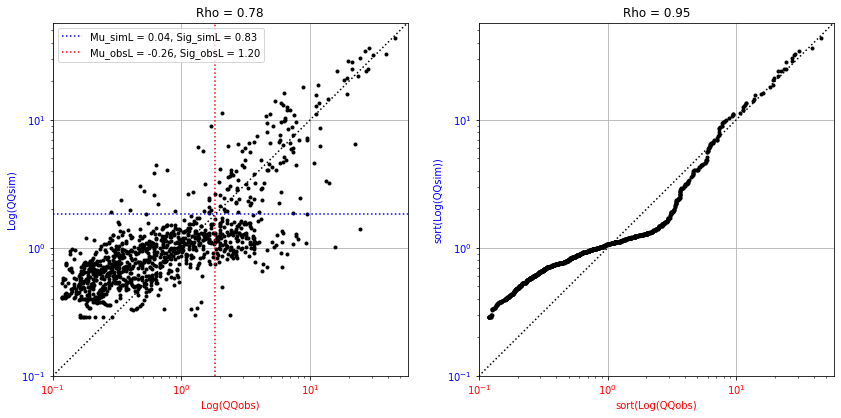

In [27]:
#==== Show Diagnostic Plots ===================================================

fignum = 0; iPrint = 1                              # set figure number
if iPrint == 1:
    DiagnosticPlots(fignum, Time, QQsim, QQobs)     # show diagnostic plots

In [12]:
#==== Plot a histogram of the resdiuals by DSM and manually calibrated models =================
ManCalPars = np.array([51,0.75,0.25,0.04,0.0002,0.56])                                  # make array of manually calibrated pars
OptimizedPars = np.array([7.71075051e+01, 5.00000000e-01, 4.90068850e-02,               # make array of optimized pars
                          1.87561126e-02, 1.00000000e-04, 5.76093034e-01])

[QQsim_manual, AEsim_manual] = MainCatchModel(ManCalPars, PPobs, PEobs, QQobs, NRes)    # store QQsim data from manually calibrated pars
[QQsim_optimized, AEsim] = MainCatchModel(OptimizedPars, PPobs, PEobs, QQobs, NRes)     # store QQsim data from optimized pars

QQobs


array([0.29 , 0.245, 0.213, ..., 0.26 , 0.211, 0.183])

In [11]:
QQsim_optimized

array([0.29      , 0.289971  , 0.289942  , ..., 1.07952717, 1.15810517,
       1.18481681])

In [18]:
QQres_manual    = QQsim_manual - QQobs
QQres_optimized = QQsim_optimized - QQobs

In [14]:
QQres_manual

array([0.        , 0.044942  , 0.07688401, ..., 1.22373921, 1.34011367,
       1.32670219])

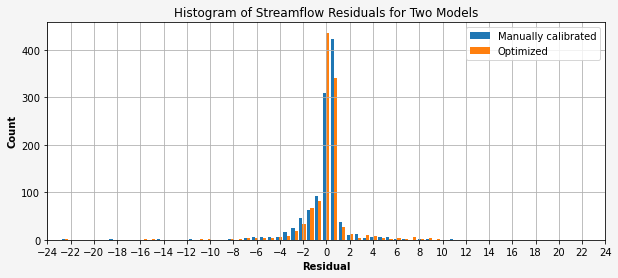

In [62]:
xticks = np.arange(-24,26,2)

fig, ax = plt.subplots(figsize=(10,4))
fig.set_facecolor('whitesmoke')
plt.hist((QQres_manual,QQres_optimized), bins=50, label=('Manually calibrated','Optimized'))
plt.ylabel('Count', fontweight='bold')
plt.xlabel('Residual', fontweight='bold')
plt.title('Histogram of Streamflow Residuals for Two Models')
plt.xticks(xticks)
plt.xlim(-24,24)
plt.grid('--k')
plt.legend()

plt.show()
